In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import binet as bt
%matplotlib inline

In [14]:
#Read data
df = pd.read_csv('fit_data_exports.csv')
df = df.replace(-np.inf, np.nan).dropna()

#Define quantile categories

def quantile_chances(df, RCA_bins = 20, T_bins = 40, xcp_bins = 40):
    df['log_RCA_cat_'+str(RCA_bins)] = ((RCA_bins/100.)*df['log_RCA'].rank(pct = True)).round(2)
    df["log_xcp_cat_"+str(xcp_bins)] = ((xcp_bins/100.)*df["log_xcp"].rank(pct = True)).round(2)
    df['T_cat_'+str(T_bins)] = ((T_bins/100.)*df.groupby('log_RCA_cat_'+str(RCA_bins))["T"].rank(pct = True)).round(2)

#     df = df[['ccode','pcode','log_RCA','log_xcp','T','RCA_bin_end','log_RCA_cat','log_xcp_cat','T_cat','ex_growth']]
    group_chances = df.groupby(['log_RCA_cat_'+str(RCA_bins),'T_cat_'+str(T_bins)]).mean().reset_index()[['log_RCA_cat_'+str(RCA_bins),'T_cat_'+str(T_bins),'RCA_bin_end']].rename(columns = {'RCA_bin_end': 'chances_'+str(RCA_bins)+'_'+str(T_bins)})
    
    return df.merge(group_chances)[['ccode','pcode','year','chances_'+str(RCA_bins)+'_'+str(T_bins)]]

In [20]:
df.sample(5)

,ccode,pcode,RCA,RCA_fin,RCA_bin_start,RCA_bin_end,year,Tc,Tp,Tw,...,log_RCA,T,ex_growth,log_RCA_cat_75,log_xcp_cat_40,T_cat_75,log_RCA_cat_65,T_cat_65,T_cat_85,log_RCA_cat_85
451292,blr,2932,0.056145,0.037717,0,0,2005,10.203398,9.795282,13.003921,...,-1.250691,6.994759,-0.118138,0.23,0.18,0.48,0.20,0.41,0.54,0.27
2019602,aut,2504,1.589738,1.648738,1,1,2013,11.216182,8.638198,13.248881,...,0.201326,6.605499,0.042155,0.63,0.28,0.25,0.55,0.22,0.29,0.72
166456,tza,8474,0.625119,0.092092,0,0,2003,8.885059,9.823616,12.859861,...,-0.204037,5.848814,-0.682378,0.52,0.17,0.11,0.45,0.10,0.13,0.59
815062,nzl,1511,0.000255,0.002957,0,0,2007,10.451766,10.244738,13.129216,...,-3.594299,7.567289,1.241286,0.01,0.03,0.53,0.00,0.46,0.60,0.01
563667,jpn,8478,0.050688,0.062666,0,0,2005,11.792123,9.191888,13.003921,...,-1.295092,7.980090,0.061561,0.22,0.26,0.68,0.19,0.59,0.77,0.25


In [21]:
quantile_chances(df, RCA_bins = 75, T_bins = 75).sample(5)

,ccode,pcode,year,chances_75_75
825260,can,8208,2013,0.008368
143916,mys,2914,2011,0.000000
101826,pan,9605,2010,0.711297
469045,chl,2815,2004,0.000000
1160545,ita,7019,2003,0.665272


In [19]:
#Here we compute the pRCA. I use slightly different bining choices so to compute mean and std of pRCA.
#This step could be done with knn or other techniques.
import itertools
quant_levels = [65,75,85] #Number of bins.
quants = list(itertools.product(quant_levels, quant_levels)) #All possible combs for 2D binnings. 

chances = pd.DataFrame()
for j, k in quants:
    chances_i = quantile_chances(df, RCA_bins = j, T_bins = k)
    if chances.empty:
        chances = chances_i
    else:
        chances = chances.merge(chances_i)
        
#From all these pRCA, get mean and std.
cols = [col for col in chances.columns if 'chances' in col]
chances['chances_mean'] = chances[cols].mean(axis = 1)
chances['chances_std'] = chances[cols].std(axis = 1)

#Keep important cols and save table
chances = chances[['ccode','pcode','year','chances_mean','chances_std']]
chances.to_csv('chances_pRCA.csv', index = False)


\begin{tabular}{llrrrr}
\toprule
{} & ccode &  pcode &  year &  chances\_mean &  chances\_std \\
\midrule
683784  &   mkd &   9209 &  2012 &      0.027485 &     0.006867 \\
430574  &   pak &   4009 &  2011 &      0.002975 &     0.002284 \\
71788   &   bgr &   2714 &  2013 &      0.030179 &     0.010721 \\
1189002 &   tun &   3206 &  2011 &      0.013956 &     0.003762 \\
1283401 &   mar &   3918 &  2008 &      0.007518 &     0.004528 \\
\bottomrule
\end{tabular}



In [25]:
print chances.sample(5).round(3).to_latex()
# chances.sample(5)

\begin{tabular}{llrrrr}
\toprule
{} & ccode &  pcode &  year &  chances\_mean &  chances\_std \\
\midrule
61111   &   mus &   2505 &  2012 &         0.249 &        0.026 \\
982701  &   cyp &   2807 &  2009 &         0.026 &        0.008 \\
833209  &   mys &   8705 &  2010 &         0.003 &        0.002 \\
1229114 &   ita &   5907 &  2013 &         0.433 &        0.031 \\
319008  &   mar &   3808 &  2007 &         0.006 &        0.005 \\
\bottomrule
\end{tabular}



### Transition probabilities for pRCA. (~ Markov chain)

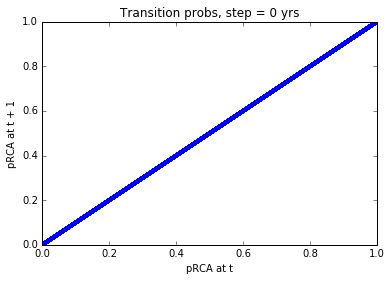

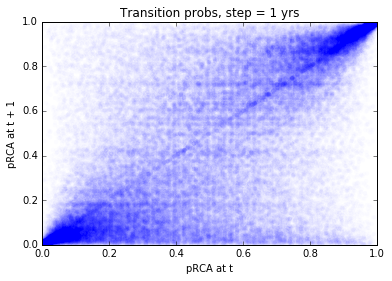

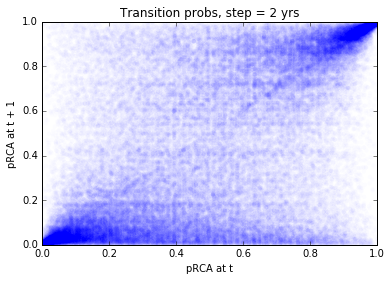

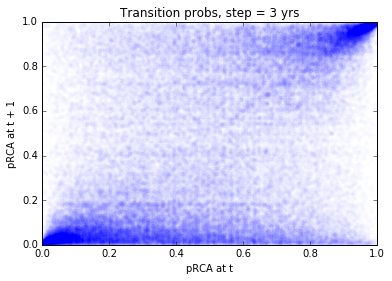

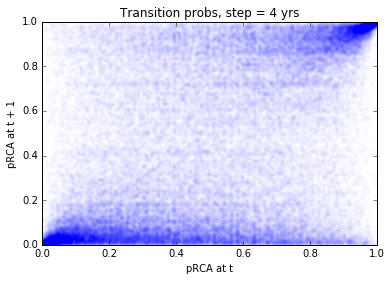

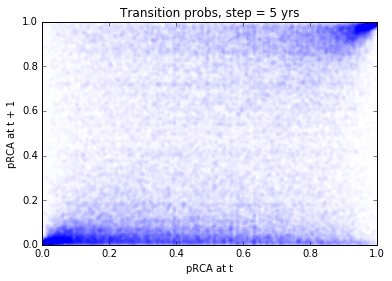

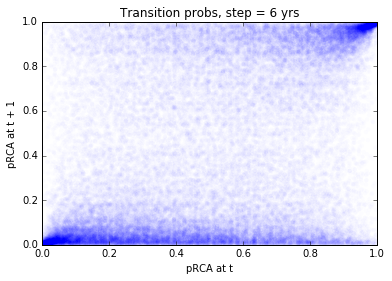

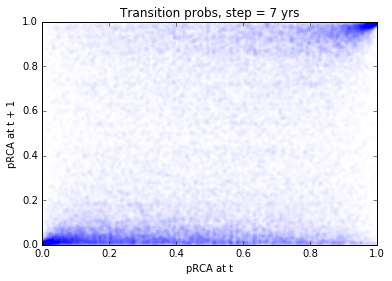

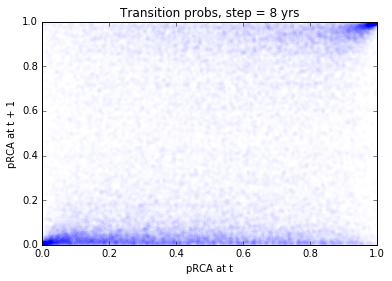

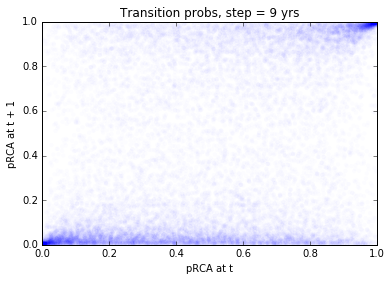

In [6]:
#Merge pRCA of subsequent years 

cpy = df[[u'ccode', u'pcode', u'year']]

#chances at t_i
chn_i = cpy.merge(chances)

#chances at t_f = t_i + step
for step in range(10):
    chn_f = chn_i.copy()
    chn_f['year'] = chn_f['year'] + step
    chn_f = chn_f[['ccode','pcode','year']].merge(chn_i)
    chn_f = chn_f.rename(columns = {'chances_mean': 'chances_mean_f', 'chances_std': 'chances_std_f'})
    chn_f['year'] = chn_f['year'] - step

    #merge, get the dynamic picture. Easy to relate to a markov chain reasoning.
    chn_dyn = chn_i.merge(chn_f)
    chn_dyn = chn_dyn#.sample(100000)

    #Subsample to have uniform distribution along x axis.
    chn_dyn['chances_mean_round'] = chn_dyn['chances_mean'].round(2)
    grouped = chn_dyn.groupby('chances_mean_round')
    unif_sampling_level = grouped.count().iloc[:, 1].min()
#     unif_sampling_level = 399 
#     print unif_sampling_level
    chn_dyn = grouped.apply(lambda x: x.sample(unif_sampling_level))

    fig = plt.figure()
    plt.scatter(chn_dyn.chances_mean, chn_dyn.chances_mean_f, edgecolor = 'None', alpha = 0.01)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('pRCA at t')
    plt.ylabel('pRCA at t + 1')
    plt.title('Transition probs, step = '+str(step)+' yrs')
    fig.savefig('Transition_p_'+str(step)+'yrstep.png')
    # # .2 and .8 seem to be natural thresholds.

In [7]:
step = 5

chn_f = chn_i.copy()
chn_f['year'] = chn_f['year'] + step
chn_f = chn_f[['ccode','pcode','year']].merge(chn_i)
chn_f = chn_f.rename(columns = {'chances_mean': 'chances_mean_f', 'chances_std': 'chances_std_f'})
chn_f['year'] = chn_f['year'] - step

#merge, get the dynamic picture. Easy to relate to a markov chain reasoning.
chn_dyn = chn_i.merge(chn_f)
chn_dyn = chn_dyn#.sample(100000)

#Subsample to have uniform distribution along x axis.
chn_dyn['chances_mean_round'] = chn_dyn['chances_mean'].round(2)
grouped = chn_dyn.groupby('chances_mean_round')
unif_sampling_level = grouped.count().iloc[:, 1].min()
#     unif_sampling_level = 399 
#     print unif_sampling_level
chn_dyn = grouped.apply(lambda x: x.sample(unif_sampling_level))

chn_dyn['cat_i'] = np.floor((chn_dyn.chances_mean + 0.4)/.6)
chn_dyn['cat_f'] = np.floor((chn_dyn.chances_mean_f + 0.4)/.6)


In [12]:
# x['cat_i'] = np.floor((x.chances_mean + 0.4)/.6)
# x['cat_f'] = np.floor((x.chances_mean_f + 0.4)/.6)

norm = np.array([3*[i] for i in chn_dyn.groupby('cat_i').count().ccode.values]).flatten()
# norm = np.array([23344, 23344, 23344,68478, 68478, 68478,23318, 23318, 23318])

100*np.true_divide(chn_dyn.groupby(['cat_i','cat_f']).count().ccode.values,norm).round(2)

array([ 75.,  18.,   8.,  42.,  35.,  23.,  16.,  19.,  65.])

In [18]:
x = chn_dyn#.sample(100000)
x['chances_mean_round'] = x['chances_mean'].round(2)
x = x.groupby('chances_mean_round').count().sort_values(by = 'year')

,ccode,pcode,year,chances_mean,chances_std,chances_mean_f,chances_std_f
chances_mean_round,,,,,,,
0.52,1141,1141,1141,1141,1141,1141,1141
0.45,1185,1185,1185,1185,1185,1185,1185
0.59,1311,1311,1311,1311,1311,1311,1311
0.49,1315,1315,1315,1315,1315,1315,1315
0.46,1345,1345,1345,1345,1345,1345,1345
0.48,1350,1350,1350,1350,1350,1350,1350
0.39,1353,1353,1353,1353,1353,1353,1353
0.47,1406,1406,1406,1406,1406,1406,1406
0.53,1416,1416,1416,1416,1416,1416,1416


In [ ]:
dg = df.merge(chances)[['ccode','pcode','year','RCA_bin_end','chances_65_65',
 'chances_65_75',
 'chances_65_85',
 'chances_75_65',
 'chances_75_75',
 'chances_75_85',
 'chances_85_65',
 'chances_85_75',
 'chances_85_85']]
co = pd.read_csv('co.csv')
pr = pd.read_csv('pr.csv')

In [ ]:
for col in cols:
    dg['performance'+str(col[-6:])] = dg['RCA_bin_end'] - dg['chances'+str(col[-6:])]
    
cols_perf = [col for col in dg.columns if 'performance' in col]
dg['perf_mean'] = dg[cols_perf].mean(axis = 1)
dg['perf_std'] = dg[cols_perf].std(axis = 1)

# dg = dg.loc[abs(dg.chances_mean - 0.5) < .6]

# x = dg.groupby('ccode').count()['pcode']
# ccode_index = x.loc[x.values > 1000].index

# x = dg.groupby('pcode').count()['ccode']
# pcode_index = x.loc[x.values > 1000].index

In [ ]:
perf = dg[['ccode','pcode','year','perf_mean']]

# perf_std = perf.groupby('ccode').std().perf_mean.reset_index().rename(columns = {'perf_mean': 'perf_std'})

# perf.groupby('ccode').mean().reset_index().merge(perf_std).merge(co).sort_values(by = 'perf_mean')


# perf.sort_values(by = 'perf_mean')

### Dataset with actual outcome and expectations.

In [ ]:
dg = df.merge(chances[['ccode','pcode','year','chances_mean','chances_std']])[['ccode','pcode','year','RCA_bin_end','chances_mean','chances_std']]
co = pd.read_csv('co.csv')
pr = pd.read_csv('pr.csv')

In [ ]:
dg['performance'] = dg['RCA_bin_end'] - dg['chances_mean']
# dg = dg.loc[abs(dg.chances_mean - 0.5) < .6]

x = dg.groupby('ccode').count()['pcode']
ccode_index = x.loc[x.values > 1000].index

x = dg.groupby('pcode').count()['ccode']
pcode_index = x.loc[x.values > 1000].index

In [ ]:
# dg.loc[dg.ccode.isin(ccode_index)].groupby('ccode').mean().reset_index().merge(co).sort_values(by = 'performance')

dg.loc[dg.pcode.isin(pcode_index)].groupby('pcode').mean().reset_index().merge(pr).sort_values(by = 'performance')